<a href="https://colab.research.google.com/github/Sukriti-Shukla/3Dreconstruction_and_augmentation/blob/main/Copy_of_3d_reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## A simple demostration of how to run

In [ ]:
# cleaning
# %rm -rf /content/3DDFA_V2

In [ ]:
# if not clone, clone it
%cd /content
!git clone https://github.com/cleardusk/3DDFA_V2.git
%cd 3DDFA_V2

/content
Cloning into '3DDFA_V2'...
remote: Enumerating objects: 706, done.
remote: Total 706 (delta 0), reused 0 (delta 0), pack-reused 706
Receiving objects: 100% (706/706), 74.78 MiB | 31.45 MiB/s, done.
Resolving deltas: 100% (366/366), done.
/content/3DDFA_V2


In [ ]:
!sh ./build.sh

Compiling nms/cpu_nms.pyx because it changed.
[1/1] Cythonizing nms/cpu_nms.pyx
/usr/local/lib/python3.10/dist-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /content/3DDFA_V2/FaceBoxes/utils/nms/cpu_nms.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
nms/cpu_nms.c: In function ‘__pyx_pf_3nms_7cpu_nms_2cpu_soft_nms’:
nms/cpu_nms.c:6247:32: warning: comparison of integer expressions of different signedness: ‘int’ and ‘unsigned int’ []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wsign-compare-Wsign-compare]8;;]
 6247 |       __pyx_t_9 = (__pyx_v_pos < __pyx_v_N);
      |                                ^
nms/cpu_nms.c:6758:32: warning: comparison of integer expressions of different signedness: ‘int’ and ‘unsigned int’ []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wsign-compare-Wsign-compare]8;;]
 6758 |       __

In [ ]:
!pip install numpy==1.23.0

In [ ]:
# before import, make sure FaceBoxes and Sim3DR are built successfully, e.g.,

import cv2
import yaml

from FaceBoxes import FaceBoxes
from TDDFA import TDDFA
from utils.render import render
from utils.depth import depth
from utils.pncc import pncc
from utils.uv import uv_tex
from utils.pose import viz_pose
from utils.serialization import ser_to_ply, ser_to_obj
from utils.functions import draw_landmarks, get_suffix

import matplotlib.pyplot as plt
from skimage import io

In [ ]:
!pip install onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 30.8 MB/s eta 0:00:00


### Load configs

In [ ]:
# load config
cfg = yaml.load(open('configs/mb1_120x120.yml'), Loader=yaml.SafeLoader)

# Init FaceBoxes and TDDFA, recommend using onnx flag
onnx_flag = True  # or True to use ONNX to speed up
if onnx_flag:
    !pip install onnxruntime

    import os
    os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
    os.environ['OMP_NUM_THREADS'] = '4'
    from FaceBoxes.FaceBoxes_ONNX import FaceBoxes_ONNX
    from TDDFA_ONNX import TDDFA_ONNX

    face_boxes = FaceBoxes_ONNX()
    tddfa = TDDFA_ONNX(**cfg)
else:
    face_boxes = FaceBoxes()
    tddfa = TDDFA(gpu_mode=False, **cfg)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.2 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/torch/onnx/utils.py:2082: UserWarning: No names were found for specified dynamic axes of provided input.Automatically generated names will be applied to each dynamic axes of input input
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/onnx/utils.py:2082: UserWarning: No names were found for specified dynamic axes of provided input.Automatically generated names will be applied to each dynamic axes of input output
  warnings.warn(


Convert /content/3DDFA_V2/FaceBoxes/weights/FaceBoxesProd.pth to /content/3DDFA_V2/FaceBoxes/weights/FaceBoxesProd.onnx done.


/usr/local/lib/python3.10/dist-packages/torch/onnx/utils.py:2082: UserWarning: No names were found for specified dynamic axes of provided input.Automatically generated names will be applied to each dynamic axes of input alpha_shp
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/onnx/utils.py:2082: UserWarning: No names were found for specified dynamic axes of provided input.Automatically generated names will be applied to each dynamic axes of input alpha_exp
  warnings.warn(


Convert configs/bfm_noneck_v3.pkl to configs/bfm_noneck_v3.onnx done.
weights/mb1_120x120.onnx does not exist, try to convert the `.pth` version to `.onnx` online
Convert weights/mb1_120x120.pth to weights/mb1_120x120.onnx done.


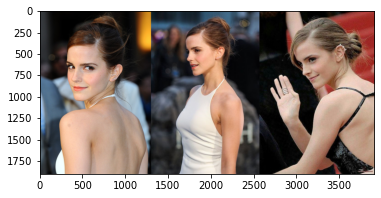

In [ ]:
# given an image path or the image url

# img_fp = 'examples/inputs/emma.jpg'
# img = cv2.imread(img_fp)
# plt.imshow(img[..., ::-1])

img_url = 'https://raw.githubusercontent.com/cleardusk/3DDFA_V2/master/examples/inputs/emma.jpg'
img = io.imread(img_url)
plt.imshow(img)

img = img[..., ::-1]  # RGB -> BGR

### Detect faces using FaceBoxes

In [ ]:
# face detection
boxes = face_boxes(img)
print(f'Detect {len(boxes)} faces')
print(boxes)

Detect 3 faces
[[1699.8103, 278.4466, 2057.8765, 762.2303, 0.999949], [2999.4954, 305.0812, 3428.5447, 900.97614, 0.99989545], [317.43112, 399.97055, 792.7798, 1048.0317, 0.99988735]]


### Regressing 3DMM parameters, reconstruction and visualization

In [ ]:
# regress 3DMM params
param_lst, roi_box_lst = tddfa(img, boxes)

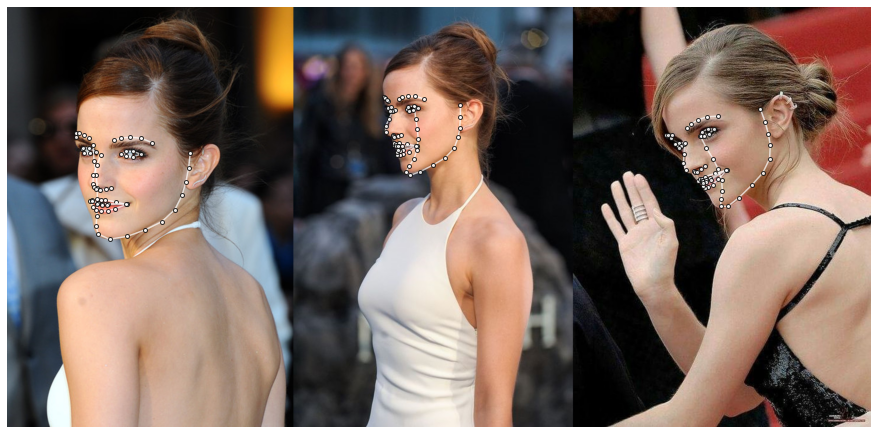

In [ ]:
# reconstruct vertices and visualizing sparse landmarks
dense_flag = False
ver_lst = tddfa.recon_vers(param_lst, roi_box_lst, dense_flag=dense_flag)
draw_landmarks(img, ver_lst, dense_flag=dense_flag)

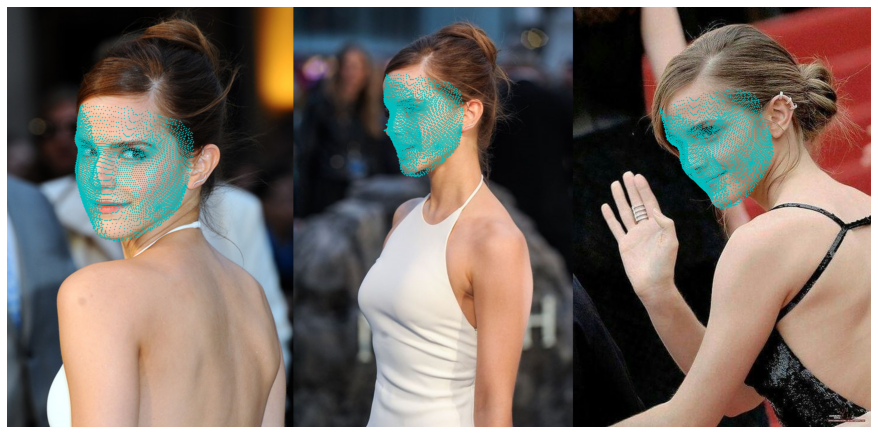

In [ ]:
# reconstruct vertices and visualizing dense landmarks
dense_flag = True
ver_lst = tddfa.recon_vers(param_lst, roi_box_lst, dense_flag=dense_flag)
draw_landmarks(img, ver_lst, dense_flag=dense_flag)

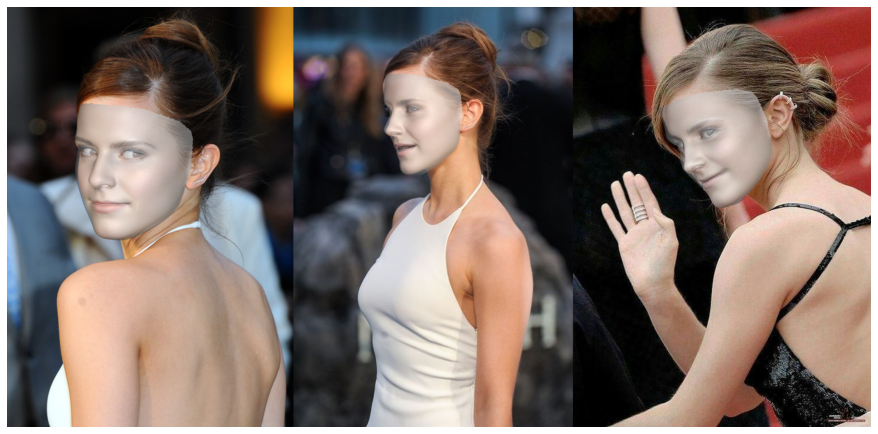

In [ ]:
# reconstruct vertices and render
ver_lst = tddfa.recon_vers(param_lst, roi_box_lst, dense_flag=dense_flag)
render(img, ver_lst, tddfa.tri, alpha=0.6, show_flag=True);

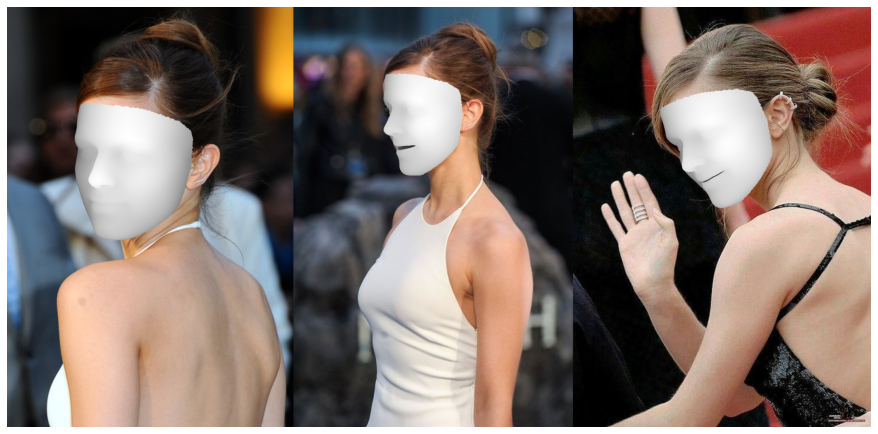

In [ ]:
# reconstruct vertices and render depth
ver_lst = tddfa.recon_vers(param_lst, roi_box_lst, dense_flag=dense_flag)
depth(img, ver_lst, tddfa.tri, show_flag=True);

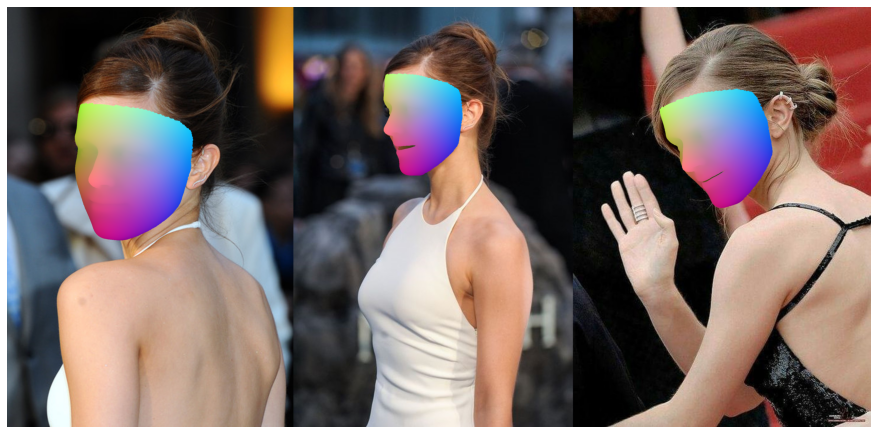

In [ ]:
# reconstruct vertices and render pncc
ver_lst = tddfa.recon_vers(param_lst, roi_box_lst, dense_flag=dense_flag)
pncc(img, ver_lst, tddfa.tri, show_flag=True);

In [ ]:
# running offline
%%bash
for OPT in 2d_sparse 2d_dense 3d depth pncc pose uv_tex ply obj; do
  python demo.py -f examples/inputs/trump_hillary.jpg -o $OPT --show_flag=false --onnx;
done;

Detect 2 faces
Save visualization result to examples/results/trump_hillary_2d_sparse.jpg
Detect 2 faces
Save visualization result to examples/results/trump_hillary_2d_dense.jpg
Detect 2 faces
Save visualization result to examples/results/trump_hillary_3d.jpg
Detect 2 faces
Save visualization result to examples/results/trump_hillary_depth.jpg
Detect 2 faces
Save visualization result to examples/results/trump_hillary_pncc.jpg
Detect 2 faces
yaw: -14.8, pitch: 7.3, roll: 14.9
yaw: -22.0, pitch: 7.5, roll: 8.1
Save visualization result to examples/results/trump_hillary_pose.jpg
Detect 2 faces
Save visualization result to examples/results/trump_hillary_uv_tex.jpg
Detect 2 faces
Dump tp examples/results/trump_hillary_ply.ply
Detect 2 faces
Dump tp examples/results/trump_hillary_obj.obj


In [ ]:
%%bash
for OPT in depth pncc; do
  python demo3.py -f examples/inputs/trump_hillary.jpg -o $OPT --show_flag=false --onnx;
done;

Detect 2 faces
Save visualization result to examples/results/trump_hillary_depth.jpg
Detect 2 faces
Save visualization result to examples/results/trump_hillary_pncc.jpg


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from subprocess import call
image_folder = '/content/drive/MyDrive/celebrity_dataset/raw/images'
opts = ['depth', 'pncc']
for filename in os.listdir(image_folder):
    if filename.endswith('.jpg') or filename.endswith('.JPG') or filename.endswith('.jpeg'):
        image_path = os.path.join(image_folder, filename)
        for opt in opts:
            command = f'python demo3.py -f "{image_path}" -o {opt} --show_flag=false --onnx'
            print(f'Running: {command}')
            call(command, shell=True)

Running: python demo3.py -f "/content/drive/MyDrive/celebrity_dataset/raw/images/m_156.jpg" -o depth --show_flag=false --onnx
Running: python demo3.py -f "/content/drive/MyDrive/celebrity_dataset/raw/images/m_156.jpg" -o pncc --show_flag=false --onnx
Running: python demo3.py -f "/content/drive/MyDrive/celebrity_dataset/raw/images/f_483.JPG" -o depth --show_flag=false --onnx
Running: python demo3.py -f "/content/drive/MyDrive/celebrity_dataset/raw/images/f_483.JPG" -o pncc --show_flag=false --onnx
Running: python demo3.py -f "/content/drive/MyDrive/celebrity_dataset/raw/images/m_181.jpg" -o depth --show_flag=false --onnx
Running: python demo3.py -f "/content/drive/MyDrive/celebrity_dataset/raw/images/m_181.jpg" -o pncc --show_flag=false --onnx
Running: python demo3.py -f "/content/drive/MyDrive/celebrity_dataset/raw/images/f_231.jpg" -o depth --show_flag=false --onnx
Running: python demo3.py -f "/content/drive/MyDrive/celebrity_dataset/raw/images/f_231.jpg" -o pncc --show_flag=false --o

In [ ]:
import os
from subprocess import call
image_folder = '/content/drive/MyDrive/celebrity_dataset/raw/images'
opts = ['uv_tex', 'obj']
for filename in os.listdir(image_folder):
    if filename.endswith('.jpg') or filename.endswith('.JPG') or filename.endswith('.jpeg'):
        image_path = os.path.join(image_folder, filename)
        for opt in opts:
            command = f'python demo2.py -f "{image_path}" -o {opt} --show_flag=false --onnx'
            print(f'Running: {command}')
            call(command, shell=True)



Running: python demo2.py -f "/content/drive/MyDrive/celebrity_dataset/raw/images/m_156.jpg" -o uv_tex --show_flag=false --onnx
Running: python demo2.py -f "/content/drive/MyDrive/celebrity_dataset/raw/images/m_156.jpg" -o obj --show_flag=false --onnx
Running: python demo2.py -f "/content/drive/MyDrive/celebrity_dataset/raw/images/f_483.JPG" -o uv_tex --show_flag=false --onnx
Running: python demo2.py -f "/content/drive/MyDrive/celebrity_dataset/raw/images/f_483.JPG" -o obj --show_flag=false --onnx
Running: python demo2.py -f "/content/drive/MyDrive/celebrity_dataset/raw/images/m_181.jpg" -o uv_tex --show_flag=false --onnx
Running: python demo2.py -f "/content/drive/MyDrive/celebrity_dataset/raw/images/m_181.jpg" -o obj --show_flag=false --onnx
Running: python demo2.py -f "/content/drive/MyDrive/celebrity_dataset/raw/images/f_231.jpg" -o uv_tex --show_flag=false --onnx
Running: python demo2.py -f "/content/drive/MyDrive/celebrity_dataset/raw/images/f_231.jpg" -o obj --show_flag=false --o

In [ ]:
!pip install pyrender trimesh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 690.2/690.2 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 858.3/858.3 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for PyOpenGL: filename=PyOpenGL-3.1.0-py3-none-any.whl size=1745193 sha256=a9bbb4d4566f58bb071b0ae83f54b533972cb9590d4fcb641d89d1ef8525fcf9
  Stored in directory: /root/.cache/pip/wheels/a1/3c/d2/1f9533f908d86176637521e533c6cdb2d4e48b59003b5c3f19
Successfully built PyOpenGL
  Attempting uninstall: PyOpenGL
    Found existing installation: PyOpenGL 3.1.7
    Uninstalling PyOpenGL-3.1.7:
      Successfully uninstalled PyOpenGL-3.1.7


In [ ]:
!pip install pyvirtualdisplay


In [ ]:
!apt-get install -y xvfb

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 32 not upgraded.
Need to get 7,814 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxfont2 amd64 1:2.0.5-1build1 [94.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxkbfile1 amd64 1:1.1.0-1build3 [71.8 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 x11-xkb-utils amd64 7.7+5build4 [172 kB]
Get:5 http://archiv

In [ ]:
import pandas as pd
import os
import numpy as np
import pyrender
import trimesh
from PIL import Image
from PIL import Image, ImageSequence
import numpy as np
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(800, 600))
virtual_display.start()

def generate_camera_poses(scene):
    poses = []
    centroid = scene.centroid
    scale = scene.scale
    if scale == 0.0:
        scale = 1.0
    s2 = 1.0 / np.sqrt(2.0)
    cp = np.eye(4)
    cp[:3, :3] = np.array([
        [0.0, -s2, s2],
        [1.0, 0.0, 0.0],
        [0.0, s2, s2]
    ])

    # https://learnopengl.com/Getting-started/Camera
    hfov = np.pi / 6.0
    dist = scale / (2.0 * np.tan(hfov))
    print(dist)
    cp[:3, 3] = dist * np.array([1.0, 0.0, 1.0]) + centroid
    poses.append(cp)
    angles = [0, -20, -45, -65, -90]
    for angle in angles:
        camera_matrix = cp
        translate_to_origin = np.eye(4)
        translate_to_origin[:3, 3] = -centroid[:3]
        theta = np.radians(angle)
        rotate_y = np.array([
            [np.cos(theta), 0, np.sin(theta), 0],
            [0, 1, 0, 0],
            [-np.sin(theta), 0, np.cos(theta), 0],
            [0, 0, 0, 1]
        ])
        translate_back = np.eye(4)
        translate_back[:3, 3] = centroid[:3]
        transformed_cp_theta = translate_back @ rotate_y @ translate_to_origin @ camera_matrix
        poses.append(transformed_cp_theta)
    return poses
directory_name = '/content/drive/MyDrive/celebrity_dataset/3d_reconstructed/'
csv_file = '/content/drive/MyDrive/celebrity_dataset/raw/annotation.csv'
df = pd.read_csv(csv_file)
for index,row in df.iterrows():
  save_path = '/content/drive/MyDrive/celebrity_dataset/multiview/'
  obj_path = directory_name+row["image"]+".obj"
  img_path = directory_name+row["image"]+".jpg"
  if not os.path.exists(img_path):
    print("file not found")
    continue;
  im = Image.open(img_path)
  mesh = trimesh.load(obj_path, process=False)
  tex = trimesh.visual.TextureVisuals(image=im)
  mesh.visual.texture = tex
  pr_mesh = pyrender.Mesh.from_trimesh(mesh)
  scene = pyrender.Scene()
  scene.add(pr_mesh)
  light = pyrender.DirectionalLight(color=np.ones(3), intensity=3.0)
  scene.add(light, pose=np.eye(4))
  renderer = pyrender.OffscreenRenderer(800, 600)
  camera_poses = generate_camera_poses(scene)
  for i, pose in enumerate(camera_poses):
      camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0)
      camera_node = scene.add(camera, pose=pose)
      color, _ = renderer.render(scene)
      img = Image.fromarray(color).rotate(90)
      #img.save(save_path+f'{row['image']}_{i}.png')
      img.save(save_path + f"{row['image']}_{i}.png")
      scene.remove_node(camera_node)
  renderer.delete()






268.61971667323365
421.51724178687465
516.811087870199
176.57766850855037
367.6986423455884
534.9432695678248
523.42087208394
469.0028397826074
129.76293244273197
437.2997142216665
663.7765058111586
591.7269970996314
489.6698116402892
283.74365124298635
142.81348163736354
288.86878014325475
232.59141747566147
226.75143388831475
323.30862474433104
298.9920943056395
360.54474097168173
335.3693206097573
296.97293037758396
462.1668073594707
1418.1895151014728
548.8093673767008
462.7332337037716
257.88164042956464
914.4970247472421
276.98642870765394
546.836100743315
295.0294782657542
143.7754952727271
406.5458293587058
842.8604692864778
311.13204382505694
339.31370298885724
241.27765363493629
256.3818033324094
1247.4048947927965
534.3050169548818
303.161839610995
243.95782223502067
777.5366949574214
1147.3780195558386
796.2395797354111
1447.5809899405406
885.9720289802855
796.1085150621043
394.06504934921566
889.8041222658729
796.7440990049427
253.3201483131184
210.93263107720784
227.09097